# Machine Learning Assignment 2

Amiru Chandrasena & Kelvin Young

# 1. Data Exploration & Pre-processing

In [2]:
# Load the dataset 
# Loading in the dataset(Data_Set.csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a pandas DataFrame, skipping the first row and using the second row as the column headers
# dataset_extraData_name = 'data/data_labels_extraData.csv'
dataset_mainData_name = 'data/data_labels_mainData.csv'

# dataset_extraData = pd.read_csv(dataset_extraData_name) 
dataset_mainData = pd.read_csv(dataset_mainData_name) 

In [3]:
dataset_mainData.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# 2. Baseline Model

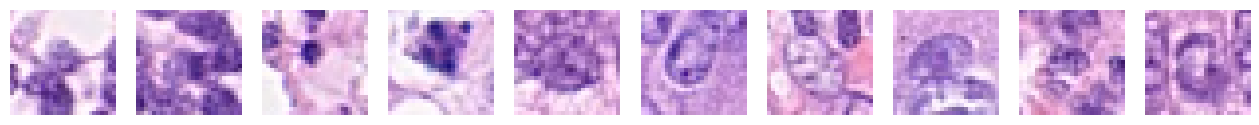

In [18]:
# Pull some random ass images 

from PIL import Image

imageCount = 100

randomImages = dataset_mainData.loc[np.random.choice(dataset_mainData.shape[0], imageCount), 'ImageName']
fileLocation = './data/patch_images/'
images = []

for imageFilename in randomImages:
    # Import image as an 3d array where the first two dimensions are the pixels, 27 by 27 resolution images
    # and then the third dimension contains rgb values of each pixel (so each pixel has an array of length 3 with the colour info)
    # Therefore, images is a list of 3 dimensional arrays
    imageArray = np.asarray(Image.open(fileLocation + imageFilename))
    images.append(imageArray)

# Show first ten images i guess
plt.figure(figsize=(16,4))
for i, image in enumerate(images[:10]):
    plt.subplot(1,10,i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [5]:
# Find isCancerous for all the random images we pulled and put it into a dataframe
# basically df_Y

classOfRandomImages = dataset_mainData.loc[dataset_mainData['ImageName'].isin(randomImages)]
classOfRandomImages = classOfRandomImages['isCancerous']
classOfRandomImages

103     0
148     0
196     0
203     0
476     1
       ..
9536    0
9683    0
9742    0
9768    0
9864    1
Name: isCancerous, Length: 100, dtype: int64

In [6]:
# Logistic regressor likes np.arrays
images = np.array(images)
classOfRandomImages = np.array(classOfRandomImages)

In [7]:
# Converts the images from 3 d arrays into a 2 d array because logistic regressor only supports up to two dimensions
# Therefore each image gets flattened into a single string of numbers
images = images.reshape(imageCount, 27*27*3)

In [9]:
images

array([[187, 156, 217, ..., 188, 141, 206],
       [227, 187, 235, ..., 211, 162, 223],
       [204, 183, 218, ..., 179, 147, 212],
       ...,
       [140,  93, 171, ..., 161, 110, 192],
       [207, 164, 225, ..., 248, 214, 240],
       [214, 176, 226, ..., 189, 151, 206]], dtype=uint8)

In [10]:
# Do train test split

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(images, classOfRandomImages, test_size=0.2, random_state=0)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

logReg = LogisticRegression(C=1, max_iter=100, solver='liblinear', class_weight='balanced', random_state=0)
logReg.fit(X_train, Y_train)

pred = logReg.predict(X_test)

In [13]:
print(f"F1 Score: {f1_score(Y_test, pred, average='macro')}")
print(f"Accuracy: {accuracy_score(Y_test, pred)}")

F1 Score: 0.5604395604395604
Accuracy: 0.6
